#### Optimización de función de temperatura con Algoritmos Genéticos

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms

In [25]:
# --- 1. Definición del Problema ---
# INPUT: (hora (formato 24 hs), temperatura de la sup. terrestre en grados Celsius)
points = [(1, 11), (10, 12), (13, 34), (22, 28)] # Datos tomados de 2 satélites diferentes

# Límites para los coeficientes del polinomio
BOUND_LOW, BOUND_UP = -20.0, 50.0 # Elegimos estos límites para que tenga cierta flexibilidad para buscar pero a la vez que no sea un espacio demasiado grande
N_VARIABLES = 4  # 4 coeficientes (a, b, c, d) porque estamos usando un polinomio cúbico

# Defino mi función fitness
def evalPolynomial(individual, points):
    """
    Evalúa el error de un polinomio cúbico.
    Individuo: [a, b, c, d] coeficientes del polinomio
    """
    a, b, c, d = individual
    
    # Calcular error (suma de cuadrados)
    error = 0.0
    for x, y in points:
        y_pred = a*x**3 + b*x**2 + c*x + d
        error += (y - y_pred)**2
    
    return (error,)

In [26]:
# --- 2. Configuración de DEAP (para individuos decimales)---
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Weights -1 porque queremos minimizar la función fitness
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Atributo generador de los individuos: valores float en el rango [BOUND_LOW, BOUND_UP]
for i in range(N_VARIABLES):
    toolbox.register(f"attr_float_{i}", random.uniform, BOUND_LOW, BOUND_UP)

# Crear individuos: lista de 4 floats [a, b, c, d]
toolbox.register("individual", tools.initCycle, creator.Individual,
                [toolbox.attr_float_0, toolbox.attr_float_1, 
                 toolbox.attr_float_2, toolbox.attr_float_3], n=1)
# Crear la población (lista de individuos)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(individual):
    """Asegura que los valores estén dentro de los límites."""
    for i in range(len(individual)):
        individual[i] = max(BOUND_LOW, min(BOUND_UP, individual[i]))
    return individual

# Definimos los operadores genéticos
toolbox.register("evaluate", evalPolynomial, points=points) # Registro mi función fitness
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Defino el mecanismo de cruza: Blend crossover 
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=3.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3) # Elegimos selección por torneo
# toolbox.decorate("mate", tools.DeltaPenalty(checkBounds, 1e10))
# toolbox.decorate("mutate", tools.DeltaPenalty(checkBounds, 1e10))

/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [27]:
# --- 3. Función para ejecutar el GA ---
def run_ga(points, pop_size=200, cxpb=0.7, mutpb=0.2, 
           ngen=500, seed=42, verbose=True):
    """Ejecuta el algoritmo genético decimal."""
    random.seed(seed)
    np.random.seed(seed)
    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, 
                                       ngen=ngen, stats=stats, 
                                       halloffame=hof, verbose=verbose)
    
    return pop, logbook, hof

In [28]:
# --- 4. Ejecución única ---
print("=== Ejecución única del GA ===\n")
pop, logbook, hof = run_ga(points, pop_size=200, ngen=500, seed=42)

best_ind = hof[0]
a, b, c, d = best_ind

print("\n--- Resultados ---")
print(f"Mejor individuo:")
print(f"  a = {a:.10f}")
print(f"  b = {b:.10f}")
print(f"  c = {c:.10f}")
print(f"  d = {d:.10f}")
print(f"Fitness (error): {best_ind.fitness.values[0]:.10f}")

# Verificación
print("\nVerificación de paso por los puntos:")
for x, y in points:
    y_pred = a*x**3 + b*x**2 + c*x + d
    error = (y - y_pred)**2
    print(f"  x={x}, y_real={y}, y_pred={y_pred:.4f}, error={error:.6e}")

=== Ejecución única del GA ===

gen	nevals	min        	avg        
0  	200   	7.75335e+06	8.17833e+10
1  	146   	8.82686e+06	2.0714e+10 
2  	160   	1.82323e+06	4.73231e+09
3  	147   	1.07268e+06	8.12556e+08
4  	145   	723258     	2.19107e+08
5  	160   	187876     	1.2187e+08 
6  	161   	235138     	8.14302e+07
7  	151   	235138     	1.27289e+08
8  	164   	235138     	8.29116e+07
9  	162   	317377     	1.07452e+08
10 	153   	317377     	6.17652e+07
11 	156   	146295     	1.20083e+08
12 	148   	22583.4    	5.67293e+07
13 	159   	22583.4    	5.14341e+07
14 	162   	22583.4    	9.51138e+07
15 	162   	22583.4    	6.2911e+07 
16 	138   	22583.4    	8.15361e+07
17 	156   	9572.37    	5.50377e+07
18 	159   	9572.37    	1.07433e+07
19 	158   	7110.46    	1.17161e+08
20 	151   	7110.46    	2.39758e+07
21 	149   	7110.46    	8.65534e+07
22 	161   	7110.46    	2.98555e+07
23 	138   	7110.46    	1.93389e+07
24 	158   	7110.46    	7.17444e+07
25 	153   	7110.46    	6.19052e+07
26 	154   	9578.72    	

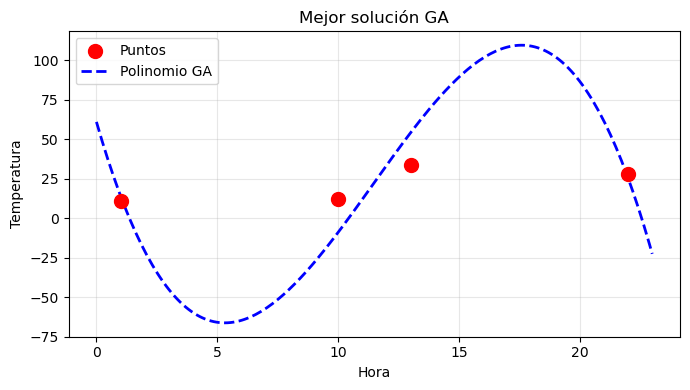

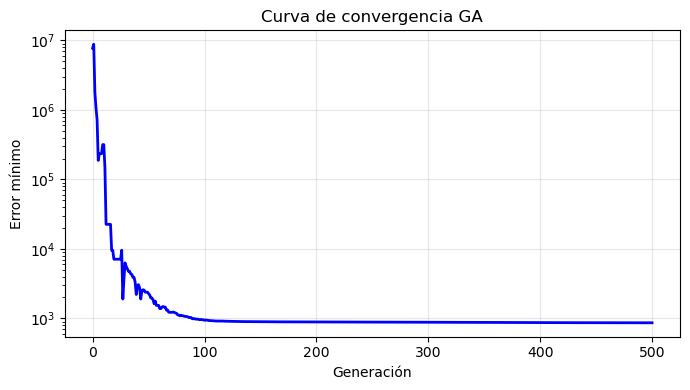

In [29]:
# --- 5. Visualización ---
def plot_solucion(coef, points, title="Mejor solución GA"):
    """Grafica la solución encontrada."""
    a, b, c, d = coef
    xs = np.linspace(min(x for x, _ in points) - 1, 
                     max(x for x, _ in points) + 1, 200)
    ys = a * xs**3 + b * xs**2 + c * xs + d
    
    plt.figure(figsize=(7, 4))
    plt.scatter(*zip(*points), color='red', label='Puntos', s=100, zorder=3)
    plt.plot(xs, ys, color='blue', linestyle='--', label='Polinomio GA', linewidth=2)
    plt.legend()
    plt.xlabel("Hora")
    plt.ylabel("Temperatura")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_solucion(best_ind, points)

# Curva de convergencia
gen = logbook.select("gen")
fit_mins = logbook.select("min")

plt.figure(figsize=(7, 4))
plt.plot(gen, fit_mins, color='blue', linewidth=2)
plt.xlabel("Generación")
plt.ylabel("Error mínimo")
plt.title("Curva de convergencia GA")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# --- 6. Evaluación con múltiples trials ---
def run_multiple_trials(points, num_trials=10, pop_size=200, ngen=500, 
                       base_seed=42, titulo='Base'):
    """Ejecuta múltiples trials del GA."""
    print(f"\n{'='*60}")
    print(f"Prueba '{titulo}' - {num_trials} trials")
    print(f"{'='*60}")
    
    final_errors = []
    convergence_curves = []
    best_overall = None
    min_error = float('inf')
    
    for trial in range(num_trials):
        seed = base_seed + trial
        pop, logbook, hof = run_ga(points, pop_size=pop_size, 
                                   ngen=ngen, seed=seed, verbose=False)
        
        best_ind = hof[0]
        error = best_ind.fitness.values[0]
        final_errors.append(error)
        
        fit_mins = logbook.select("min")
        convergence_curves.append(fit_mins)
        
        print(f"  Trial {trial+1:2d} (seed={seed:3d}): Error = {error:.6e}")
        
        if error < min_error:
            min_error = error
            best_overall = list(best_ind)
    
    return final_errors, convergence_curves, best_overall

# Ejecutar 3 variantes
print("\n" + "="*60)
print("EVALUACIÓN DE HIPERPARÁMETROS")
print("="*60)

errors_base, curves_base, coef_base = run_multiple_trials(
    points, num_trials=20, pop_size=200, ngen=500, titulo='Base')

errors_var1, curves_var1, coef_var1 = run_multiple_trials(
    points, num_trials=20, pop_size=400, ngen=800, titulo='+población')

errors_var2, curves_var2, coef_var2 = run_multiple_trials(
    points, num_trials=20, pop_size=100, ngen=500, titulo='-población')


EVALUACIÓN DE HIPERPARÁMETROS

Prueba 'Base' - 20 trials
  Trial  1 (seed= 42): Error = 8.638510e+02
  Trial  2 (seed= 43): Error = 2.559715e+01
  Trial  3 (seed= 44): Error = 2.976271e+02
  Trial  4 (seed= 45): Error = 4.875744e+00
  Trial  5 (seed= 46): Error = 6.589503e+00
  Trial  6 (seed= 47): Error = 5.266640e+02
  Trial  7 (seed= 48): Error = 1.361208e+03
  Trial  8 (seed= 49): Error = 1.072917e+03
  Trial  9 (seed= 50): Error = 4.831191e-01
  Trial 10 (seed= 51): Error = 5.880369e+02
  Trial 11 (seed= 52): Error = 2.558573e+01
  Trial 12 (seed= 53): Error = 2.108370e+03
  Trial 13 (seed= 54): Error = 8.059136e+02
  Trial 14 (seed= 55): Error = 4.164086e+02
  Trial 15 (seed= 56): Error = 1.895705e+01
  Trial 16 (seed= 57): Error = 1.662024e+02
  Trial 17 (seed= 58): Error = 7.053497e+00
  Trial 18 (seed= 59): Error = 5.955629e+02
  Trial 19 (seed= 60): Error = 1.556839e+01
  Trial 20 (seed= 61): Error = 1.422996e+01

Prueba '+población' - 20 trials
  Trial  1 (seed= 42): Error 

In [31]:
# --- 7. Tabla de comparación ---
data = {
    'Variante': ['Base', '+población', '-población'],
    'Error Medio': [np.mean(errors_base), np.mean(errors_var1), np.mean(errors_var2)],
    'Error Std': [np.std(errors_base), np.std(errors_var1), np.std(errors_var2)],
    'Error Min': [np.min(errors_base), np.min(errors_var1), np.min(errors_var2)],
    'Error Max': [np.max(errors_base), np.max(errors_var1), np.max(errors_var2)]
}
df = pd.DataFrame(data)
print("\n" + "="*60)
print("TABLA DE COMPARACIÓN")
print("="*60)
print(df.to_string(index=False))


TABLA DE COMPARACIÓN
  Variante  Error Medio   Error Std  Error Min    Error Max
      Base   446.085060  553.843312   0.483119  2108.369642
+población   204.765212  260.528469   3.241841   799.552501
-población  1809.383867 4295.532490   6.450059 19979.500025


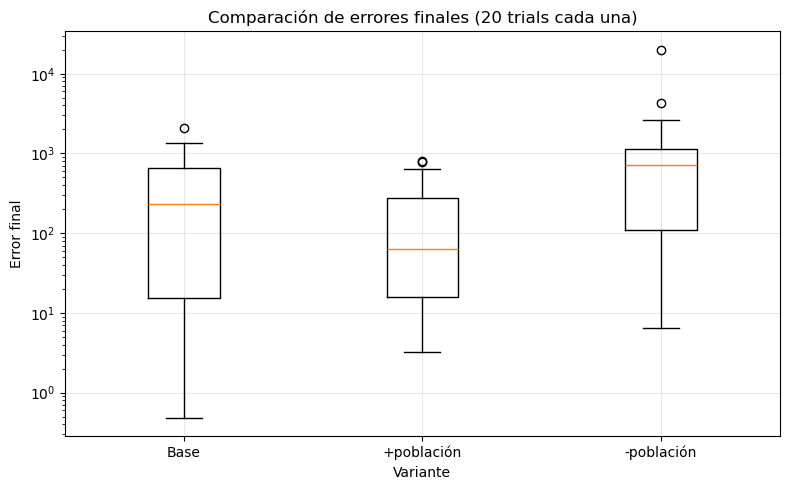

In [32]:
# --- 8. Boxplots ---
plt.figure(figsize=(8, 5))
plt.boxplot([errors_base, errors_var1, errors_var2], 
            tick_labels=['Base', '+población', '-población'])
plt.xlabel("Variante")
plt.ylabel("Error final")
plt.title("Comparación de errores finales (20 trials cada una)")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

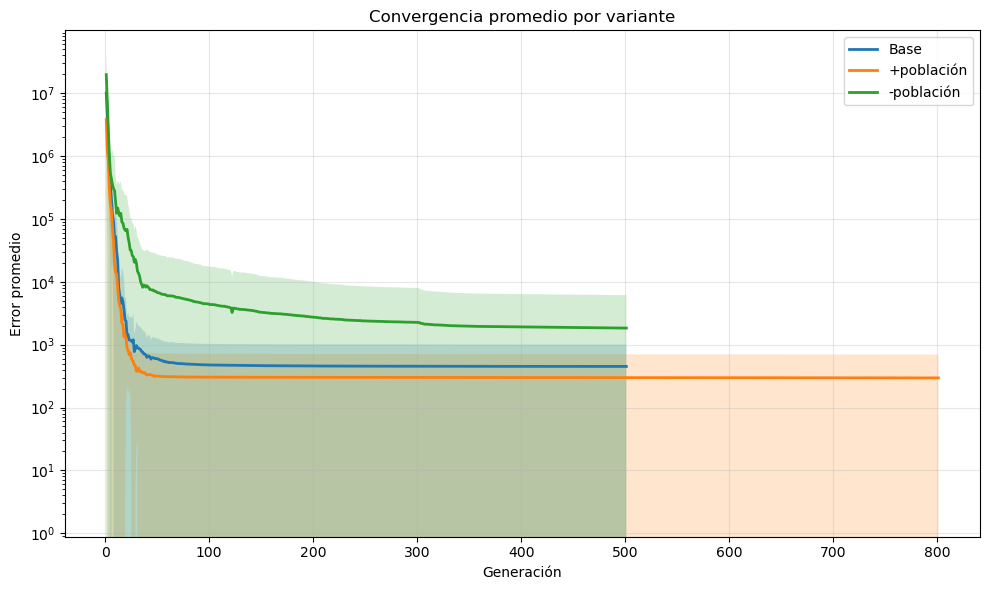

In [33]:
# --- 9. Convergencia promedio ---
def plot_average_convergence(curves_list, label):
    """Grafica la convergencia promedio con banda de desviación estándar."""
    max_len = max(len(c) for c in curves_list)
    padded_curves = [c + [c[-1]] * (max_len - len(c)) for c in curves_list]
    avg_curve = np.mean(padded_curves, axis=0)
    std_curve = np.std(padded_curves, axis=0)
    gens = np.arange(1, max_len + 1)
    plt.plot(gens, avg_curve, label=label, linewidth=2)
    plt.fill_between(gens, avg_curve - std_curve, avg_curve + std_curve, alpha=0.2)

plt.figure(figsize=(10, 6))
plot_average_convergence(curves_base, 'Base')
plot_average_convergence(curves_var1, '+población')
plot_average_convergence(curves_var2, '-población')
plt.xlabel("Generación")
plt.ylabel("Error promedio")
plt.title("Convergencia promedio por variante")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


MEJOR SOLUCIÓN GENERAL
Coeficientes: a=-0.061263, b=2.086563, c=-16.144600, d=25.654174


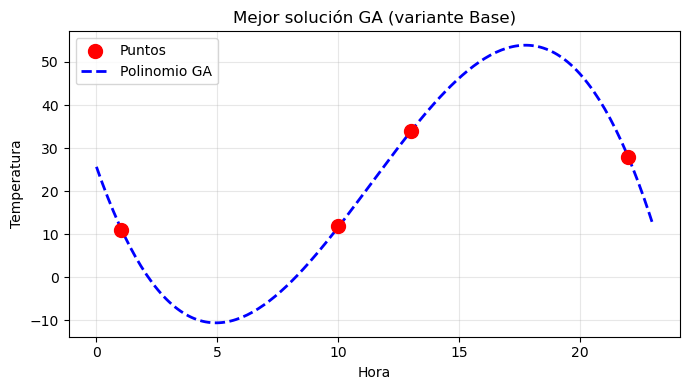

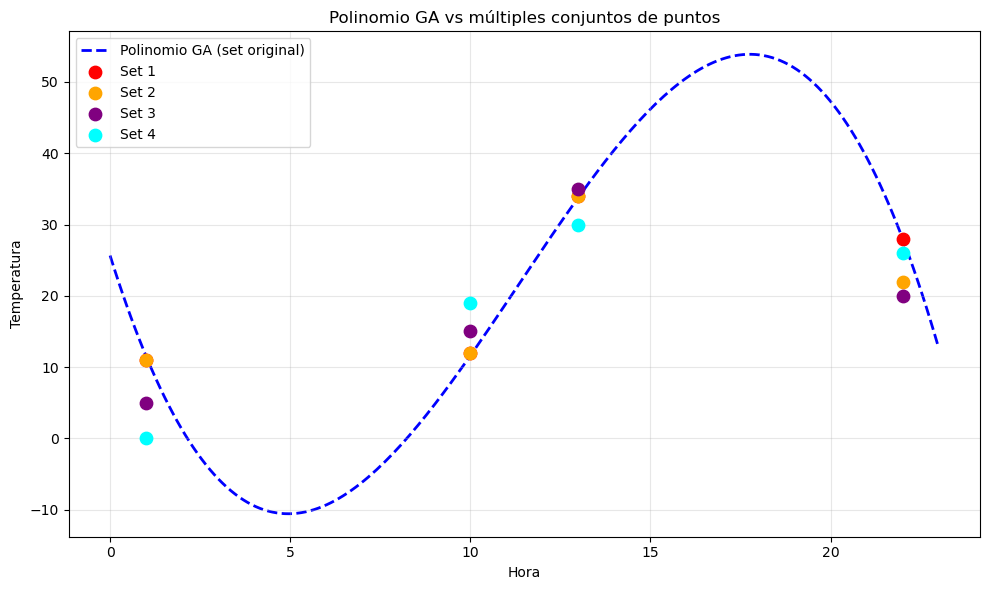


ERRORES POR CONJUNTO DE PUNTOS
  Set  Error Total      Punto 1      Punto 2      Punto 3      Punto 4
Set 1 4.831191e-01 2.860898e-01 1.587432e-01 3.650445e-02 1.781586e-03
Set 2 3.698963e+01 2.860898e-01 1.587432e-01 3.650445e-02 3.650829e+01
Set 3 1.203496e+02 4.270457e+01 1.154930e+01 1.418627e+00 6.467712e+01
Set 4 2.064686e+02 1.330533e+02 5.473671e+01 1.450801e+01 4.170617e+00


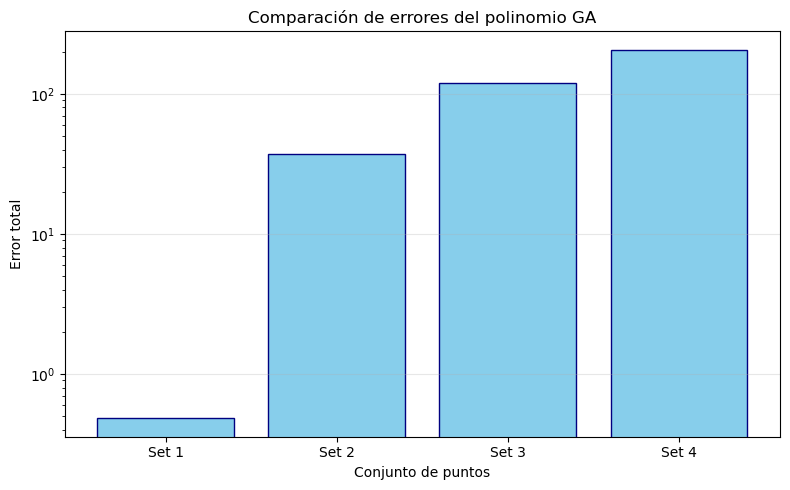

In [34]:
# --- 10. Mejor solución general ---
print("\n" + "="*60)
print("MEJOR SOLUCIÓN GENERAL")
print("="*60)
a, b, c, d = coef_base
print(f"Coeficientes: a={a:.6f}, b={b:.6f}, c={c:.6f}, d={d:.6f}")
plot_solucion(coef_base, points, "Mejor solución GA (variante Base)")

# --- 11. Validación con otros conjuntos de puntos ---
point_sets = [
    [(1, 11), (10, 12), (13, 34), (22, 28)],  # Original
    [(1, 11), (10, 12), (13, 34), (22, 22)],   
    [(1, 5), (10, 15), (13, 35), (22, 20)], 
    [(1, 0), (10, 19), (13, 30), (22, 26)]
]

xs = np.linspace(0, 23, 200)
ys_ga = a * xs**3 + b * xs**2 + c * xs + d

plt.figure(figsize=(10, 6))
colors = ['red', 'orange', 'purple', 'cyan']

plt.plot(xs, ys_ga, color='blue', linestyle='--', 
         label='Polinomio GA (set original)', linewidth=2, zorder=1)

for idx, pts in enumerate(point_sets):
    plt.scatter([x for x, _ in pts], [y for _, y in pts], 
               color=colors[idx], label=f'Set {idx+1}', s=80, zorder=2)

plt.legend()
plt.xlabel("Hora")
plt.ylabel("Temperatura")
plt.title("Polinomio GA vs múltiples conjuntos de puntos")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tabla de errores por conjunto
errors_data = []
for idx, pts in enumerate(point_sets, 1):
    error_total = 0.0
    individual_errors = []
    for x, y in pts:
        y_pred = a*x**3 + b*x**2 + c*x + d
        err = (y - y_pred)**2
        individual_errors.append(err)
        error_total += err
    
    errors_data.append({
        'Set': f'Set {idx}',
        'Error Total': f"{error_total:.6e}",
        'Punto 1': f"{individual_errors[0]:.6e}",
        'Punto 2': f"{individual_errors[1]:.6e}",
        'Punto 3': f"{individual_errors[2]:.6e}",
        'Punto 4': f"{individual_errors[3]:.6e}"
    })

df_errors = pd.DataFrame(errors_data)
print("\n" + "="*60)
print("ERRORES POR CONJUNTO DE PUNTOS")
print("="*60)
print(df_errors.to_string(index=False))

# Gráfico de barras
plt.figure(figsize=(8, 5))
errors_total = [sum((a*x**3 + b*x**2 + c*x + d - y)**2 for x, y in pts) 
                for pts in point_sets]
sets = [f'Set {i+1}' for i in range(len(point_sets))]
plt.bar(sets, errors_total, color='skyblue', edgecolor='navy')
plt.xlabel("Conjunto de puntos")
plt.ylabel("Error total")
plt.title("Comparación de errores del polinomio GA")
plt.yscale('log')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
### 2. Evaluación del algoritmo
---

#### 2.1 Consistencia (evaluar qué sucede si ejecuto el algoritmo en condiciones idénticas)

#### 2.2 Estabilidad (evaluar qué sucede si ejecuto el algoritmo variando los parámetros)